In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
%pip install -q tensorflow-recommenders
%pip install -q --upgrade tensorflow-datasets
%pip install -q tensorflow-ranking

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.optimizers import Adam
import tensorflow_recommenders as tfrs
import tensorflow_ranking as tfr

from typing import Dict, Text

import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [4]:
data = pd.read_csv('D:/capston_ml/tfrs/dataset/clean_data.csv', nrows=100000)

In [5]:
def preprocessing(df):
    
    #change to only year
    df['date_time'] = pd.to_datetime(df['date_time'], format = '%Y-%m-%d').dt.year 
    
    # if number of adult is 0, normally it means 1:
    df['srch_adults_cnt'] = df['srch_adults_cnt'].map(lambda x: 1 if x == 0 else x)
    
    # if number of room is 0, normally it means 1:
    df['srch_rm_cnt'] = df['srch_rm_cnt'].map(lambda x: 1 if x == 0 else x)

    #categorise to 1 for short stay (1 day), 2 for normal stay (2 days to a week) and 3 for long stay (more than a week)
    df['stay_length'] = df['stay_length'].map(lambda x: 1 if x<=1 else(2 if x in range(2, 8) else 3))
    
    #categorise to 1 for urgent booking (1 day), 2 for normal booking (2 days to a month in advance) and 3 for advance booking (more than a month prior)
    df['days_to_checkin']= df['days_to_checkin'].map(lambda x: 1 if x<=1 else(2 if x in range(2, 30) else 3))
    
    return df

data = preprocessing(data)

In [6]:
most_popular_hotel_clusters = list(data['hotel_cluster'].value_counts()[:].index)
data_sub = data[data['hotel_cluster'].map(lambda x: x in most_popular_hotel_clusters)]
data_sub = data_sub[:]

preference = data_sub.drop(['date_time','cnt'], axis = 1).astype(str)
hotel_cluster = data_sub[['hotel_cluster']].astype(str)

In [7]:
# changing data to tf.Dataset format

preference = tf.data.Dataset.from_tensor_slices(dict(preference))
preference = preference.map(lambda x: {'hotel_cluster': x['hotel_cluster'],
                                       'user_id': x['user_id'],
                                       'user_location_city': x['user_location_city'],
                                       'is_mobile': x['is_mobile'],
                                       'is_package': x['is_package'],
                                       'channel': x['channel'],
                                       'srch_adults_cnt': x['srch_adults_cnt'],
                                       'srch_children_cnt': x['srch_children_cnt'],
                                       'srch_rm_cnt': x['srch_rm_cnt'],
                                       'srch_destination_id': x['srch_destination_id'],
                                       'hotel_market': x['hotel_market'],
                                       'days_to_checkin': x['days_to_checkin'],
                                       'stay_length': x['stay_length'],
                                       'month_of_booking': x['month_of_booking'],
                                       'month_of_staying': x['month_of_staying']
                                      }
                           )

unique = hotel_cluster['hotel_cluster'].unique()
unique = pd.DataFrame(unique)
unique.columns = ['hotel_cluster']
hotel_cluster = tf.data.Dataset.from_tensor_slices(dict(unique))
hotel_cluster = hotel_cluster.map(lambda x: x['hotel_cluster'])

In [8]:
def convert_tensor_to_mapX_format(index, test): 

    '''
    Function to map output of BruteForce Layer to nested list format for input to ML Metrics
    
    '''
    
    df = test.map(lambda x: {'user_id': x['user_id'],
                             'user_location_city': x['user_location_city'],
                             'is_mobile': x['is_mobile'],
                             'is_package': x['is_package'],
                             'channel': x['channel'],
                             'srch_adults_cnt': x['srch_adults_cnt'],
                             'srch_children_cnt': x['srch_children_cnt'],
                             'srch_rm_cnt': x['srch_rm_cnt'],
                             'srch_destination_id': x['srch_destination_id'],
                             'hotel_market': x['hotel_market'],
                             'days_to_checkin': x['days_to_checkin'],
                             'stay_length': x['stay_length'],
                             'month_of_booking': x['month_of_booking'],
                             'month_of_staying': x['month_of_staying']
                              }
                   )
    prediction = []

    for row in df.batch(8192):
        top = index(row)[1].numpy()[:, :5]
        prediction += pd.DataFrame(top).apply(lambda x: [x[i].decode('utf-8') for i in range(len(x))], axis = 1).tolist()    
    
    return prediction

In [9]:
class QueryModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()             

        embedding_dimension = 32
        
        # Embedding for all the features related to the user
        
        self.user_id_lookup = StringLookup()
        self.user_id_lookup.adapt(preference.map(lambda x: x['user_id']))
        self.user_id_embedding = Embedding(self.user_id_lookup.vocabulary_size(), embedding_dimension)
        self.user_id_model = Sequential([self.user_id_lookup, self.user_id_embedding])
        
        self.user_location_city_lookup = StringLookup()
        self.user_location_city_lookup.adapt(preference.map(lambda x: x['user_location_city']))
        self.user_location_city_embedding = Embedding(self.user_location_city_lookup.vocabulary_size(), embedding_dimension)
        self.user_location_city_model = Sequential([self.user_location_city_lookup, self.user_location_city_embedding])
        
        self.is_mobile_lookup = StringLookup()
        self.is_mobile_lookup.adapt(preference.map(lambda x: x['is_mobile']))
        self.is_mobile_embedding = Embedding(self.is_mobile_lookup.vocabulary_size(), embedding_dimension)
        self.is_mobile_model = Sequential([self.is_mobile_lookup, self.is_mobile_embedding])
        
        self.is_package_lookup = StringLookup()
        self.is_package_lookup.adapt(preference.map(lambda x: x['is_package']))
        self.is_package_embedding = Embedding(self.is_package_lookup.vocabulary_size(), embedding_dimension)
        self.is_package_model = Sequential([self.is_package_lookup, self.is_package_embedding])
        
        self.channel_lookup = StringLookup()
        self.channel_lookup.adapt(preference.map(lambda x: x['channel']))
        self.channel_embedding = Embedding(self.channel_lookup.vocabulary_size(), embedding_dimension)
        self.channel_model = Sequential([self.channel_lookup, self.channel_embedding])

        self.srch_adults_cnt_lookup = StringLookup()
        self.srch_adults_cnt_lookup.adapt(preference.map(lambda x: x['srch_adults_cnt']))
        self.srch_adults_cnt_embedding = Embedding(self.srch_adults_cnt_lookup.vocabulary_size(), embedding_dimension)
        self.srch_adults_cnt_model = Sequential([self.srch_adults_cnt_lookup, self.srch_adults_cnt_embedding])        

        self.srch_children_cnt_lookup = StringLookup()
        self.srch_children_cnt_lookup.adapt(preference.map(lambda x: x['srch_children_cnt']))
        self.srch_children_cnt_embedding = Embedding(self.srch_children_cnt_lookup.vocabulary_size(), embedding_dimension)
        self.srch_children_cnt_model = Sequential([self.srch_children_cnt_lookup, self.srch_children_cnt_embedding])     

        self.srch_rm_cnt_lookup = StringLookup()
        self.srch_rm_cnt_lookup.adapt(preference.map(lambda x: x['srch_rm_cnt']))
        self.srch_rm_cnt_embedding = Embedding(self.srch_rm_cnt_lookup.vocabulary_size(), embedding_dimension)
        self.srch_rm_cnt_model = Sequential([self.srch_rm_cnt_lookup, self.srch_rm_cnt_embedding])   
        
        self.srch_destination_id_lookup = StringLookup()
        self.srch_destination_id_lookup.adapt(preference.map(lambda x: x['srch_destination_id']))
        self.srch_destination_id_embedding = Embedding(self.srch_destination_id_lookup.vocabulary_size(), embedding_dimension)
        self.srch_destination_id_model = Sequential([self.srch_destination_id_lookup, self.srch_destination_id_embedding])
         
        self.hotel_market_lookup = StringLookup()
        self.hotel_market_lookup.adapt(preference.map(lambda x: x['hotel_market']))
        self.hotel_market_embedding = Embedding(self.hotel_market_lookup.vocabulary_size(), embedding_dimension)
        self.hotel_market_model = Sequential([self.hotel_market_lookup, self.hotel_market_embedding])       
 
        self.days_to_checkin_lookup = StringLookup()
        self.days_to_checkin_lookup.adapt(preference.map(lambda x: x['days_to_checkin']))
        self.days_to_checkin_embedding = Embedding(self.days_to_checkin_lookup.vocabulary_size(), embedding_dimension)
        self.days_to_checkin_model = Sequential([self.days_to_checkin_lookup, self.days_to_checkin_embedding])            
        
        self.stay_length_lookup = StringLookup()
        self.stay_length_lookup.adapt(preference.map(lambda x: x['stay_length']))
        self.stay_length_embedding = Embedding(self.stay_length_lookup.vocabulary_size(), embedding_dimension)
        self.stay_length_model = Sequential([self.stay_length_lookup, self.stay_length_embedding])      
                
        self.month_of_booking_lookup = StringLookup()
        self.month_of_booking_lookup.adapt(preference.map(lambda x: x['month_of_booking']))
        self.month_of_booking_embedding = Embedding(self.month_of_booking_lookup.vocabulary_size(), embedding_dimension)
        self.month_of_booking_model = Sequential([self.month_of_booking_lookup, self.month_of_booking_embedding])      
                
        self.month_of_staying_lookup = StringLookup()
        self.month_of_staying_lookup.adapt(preference.map(lambda x: x['month_of_staying']))
        self.month_of_staying_embedding = Embedding(self.month_of_staying_lookup.vocabulary_size(), embedding_dimension)
        self.month_of_staying_model = Sequential([self.month_of_staying_lookup, self.month_of_staying_embedding])    
        
        
    def call(self, inputs):
        
    # Take the input dictionary, pass it through each input layer and concatenate the result.
    
        return tf.concat([
            self.user_id_model(inputs["user_id"]),
            self.user_location_city_model(inputs["user_location_city"]),
            self.is_mobile_model(inputs["is_mobile"]),
            self.is_package_model(inputs["is_package"]),
            self.channel_model(inputs["channel"]),
            self.srch_adults_cnt_model(inputs["srch_adults_cnt"]),
            self.srch_children_cnt_model(inputs["srch_children_cnt"]),
            self.srch_rm_cnt_model(inputs["srch_rm_cnt"]),
            self.srch_destination_id_model(inputs["srch_destination_id"]),
            self.hotel_market_model(inputs["hotel_market"]),
            self.days_to_checkin_model(inputs["days_to_checkin"]),
            self.stay_length_model(inputs["stay_length"]),
            self.month_of_booking_model(inputs["month_of_booking"]),
            self.month_of_staying_model(inputs["month_of_staying"])
            
        ], axis=1)

In [10]:
class CandidateModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()     

        embedding_dimension = 32 

        self.hotel_cluster_lookup = StringLookup()
        self.hotel_cluster_lookup.adapt(preference.map(lambda x: x['hotel_cluster']))
        self.hotel_cluster_embedding = Embedding(self.hotel_cluster_lookup.vocabulary_size(), embedding_dimension)
        self.hotel_cluster_model = Sequential([self.hotel_cluster_lookup, self.hotel_cluster_embedding])

    def call(self, inputs):
    
        return tf.concat([
            self.hotel_cluster_model(inputs),            
        ], axis=1)

In [11]:
class RetrievalModelAdvanced(tfrs.models.Model):
    
    def __init__(self):
        super().__init__()

        # calling the QueryModel and putting another layer to shape the number of outputs
        self.query_model = Sequential([
            QueryModel(),
            Dense(32)
        ])
        
        # calling the Candidate Model and putting another layer to shape the number of outputs
        self.candidate_model = Sequential([
            CandidateModel(),
            Dense(32)
        ])
        
        metrics = tfrs.metrics.FactorizedTopK(candidates = hotel_cluster.batch(128).map(self.candidate_model))                  
        self.task = tfrs.tasks.Retrieval(metrics = metrics);
            
    def compute_loss(self, features, training=False):
        
        query_embeddings = self.query_model({
            'user_id': features['user_id'],
            'user_location_city': features['user_location_city'],
            'is_mobile': features['is_mobile'],
            'is_package': features['is_package'],
            'channel': features['channel'],
            'srch_adults_cnt': features['srch_adults_cnt'],
            'srch_children_cnt': features['srch_children_cnt'],
            'srch_rm_cnt': features['srch_rm_cnt'],
            'srch_destination_id': features['srch_destination_id'],
            'hotel_market': features['hotel_market'],
            'days_to_checkin': features['days_to_checkin'],
            'stay_length': features['stay_length'],
            'month_of_booking': features['month_of_booking'],
            'month_of_staying': features['month_of_staying'],
        })
        
        hotel_embeddings = self.candidate_model(features['hotel_cluster'])

        return self.task(query_embeddings, hotel_embeddings)

In [12]:
# train_test_split

tf.random.set_seed(16)

datasize = len(data_sub)
test_ratio = 0.25
train_size = int((1- test_ratio) * datasize)
test_size = int(test_ratio * datasize)

shuffled = preference.shuffle(datasize, seed=16, reshuffle_each_iteration=False)
train = shuffled.take(train_size)
test = shuffled.skip(train_size).take(test_size)

cached_train = train.shuffle(datasize).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [13]:
model = RetrievalModelAdvanced()
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [14]:
# logdir="../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# %tensorboard --logdir {logdir}

#  ,callbacks = [tensorboard_callback]

In [15]:
history = model.fit(cached_train, validation_data=cached_test, epochs=5, batch_size = 8192)

Epoch 1/5
10/10 [==============================] - 28s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0185 - factorized_top_k/top_5_categorical_accuracy: 0.0963 - factorized_top_k/top_10_categorical_accuracy: 0.1674 - factorized_top_k/top_50_categorical_accuracy: 0.5716 - factorized_top_k/top_100_categorical_accuracy: 0.9973 - loss: 114236.3778 - regularization_loss: 0.0000e+00 - total_loss: 114236.3778 - val_factorized_top_k/top_1_categorical_accuracy: 0.0316 - val_factorized_top_k/top_5_categorical_accuracy: 0.1778 - val_factorized_top_k/top_10_categorical_accuracy: 0.2931 - val_factorized_top_k/top_50_categorical_accuracy: 0.7552 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 2439.9531 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2439.9531
Epoch 2/5
10/10 [==============================] - 15s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0478 - factorized_top_k/top_5_categorical_accuracy: 0.2417 - factorized_top_k/top_10_cate

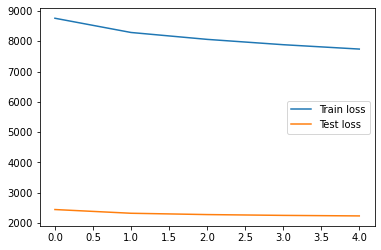

In [16]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend();

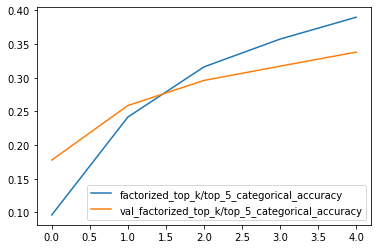

In [17]:
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'], label = 'factorized_top_k/top_5_categorical_accuracy')
plt.plot(history.history['val_factorized_top_k/top_5_categorical_accuracy'], label = 'val_factorized_top_k/top_5_categorical_accuracy')
plt.legend();

In [18]:
model.evaluate(cached_train, return_dict=True)

10/10 [==============================] - 9s 859ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1068 - factorized_top_k/top_5_categorical_accuracy: 0.4235 - factorized_top_k/top_10_categorical_accuracy: 0.5860 - factorized_top_k/top_50_categorical_accuracy: 0.9337 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 54071.0453 - regularization_loss: 0.0000e+00 - total_loss: 54071.0453


{'factorized_top_k/top_1_categorical_accuracy': 0.10678666830062866,
 'factorized_top_k/top_5_categorical_accuracy': 0.4235466718673706,
 'factorized_top_k/top_10_categorical_accuracy': 0.5859866738319397,
 'factorized_top_k/top_50_categorical_accuracy': 0.9337199926376343,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 7592.4111328125,
 'regularization_loss': 0,
 'total_loss': 7592.4111328125}

In [19]:
model.evaluate(cached_test, return_dict=True)

7/7 [==============================] - 2s 311ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0807 - factorized_top_k/top_5_categorical_accuracy: 0.3381 - factorized_top_k/top_10_categorical_accuracy: 0.4867 - factorized_top_k/top_50_categorical_accuracy: 0.8886 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 23491.2487 - regularization_loss: 0.0000e+00 - total_loss: 23491.2487


{'factorized_top_k/top_1_categorical_accuracy': 0.0806799978017807,
 'factorized_top_k/top_5_categorical_accuracy': 0.3381200134754181,
 'factorized_top_k/top_10_categorical_accuracy': 0.4867199957370758,
 'factorized_top_k/top_50_categorical_accuracy': 0.8885999917984009,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 2229.075927734375,
 'regularization_loss': 0,
 'total_loss': 2229.075927734375}

In [44]:
# Use brute-force search to set up retrieval

index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
index.index_from_dataset(hotel_cluster.batch(1000).map(model.candidate_model))

In [47]:
# Recommendation for 1 input

input = {'user_id': tf.constant(['12']),
         'user_location_city': tf.constant(['41898']),
         'is_mobile': tf.constant(['0']),
         'is_package': tf.constant(['0']),
         'channel': tf.constant(['0']),
         'srch_adults_cnt': tf.constant(['2']),
         'srch_children_cnt': tf.constant(['2']),
         'srch_rm_cnt': tf.constant(['1']),
         'srch_destination_id': tf.constant(['53']),
         'hotel_market': tf.constant(['53']),
         'days_to_checkin': tf.constant(['1']),
         'stay_length': tf.constant(['1']),
         'month_of_booking': tf.constant(['4']),
         'month_of_staying': tf.constant(['6']),
         
        }

score, recommend = index(input)

print(f"Top 5 recommendations for user 94390: {recommend[0, :10]}")
print(f'Scores for top 5: {score[0, :5]}')

Top 5 recommendations for user 94390: [70 69 42 81 44 10 36 20 47 33]
Scores for top 5: [2.0061088 1.8982155 1.8571713 1.8361195 1.8234414]
